<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 4 (Weeks 8,9): Convolutional Neural Networks (CNNs)</p>
## <p style="text-align: center;">Notebook II: Applications</p>

<img src="https://miro.medium.com/v2/resize:fit:592/1*V6Y8FF2qfw_ztNbs1AHXNg.png" width="800" height="400" />

<!-- ![linear-vs-logistic-regression--medium](https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg) -->

Welcome to the fourth and <b>final</b> lab! As usual, this lab will span over two weeks.
            
In this Lab, you will find four tasks distributed across two Jupyter Notebooks: *Lab4_Basics_student.ipynb* and *Lab4_Applications_student.ipynb*. The first two tasks guide you to train a basic CNN using pytorch lightning. In the last task, you will apply the knowledge you gained to solve a practical problem.
    
- <b>Task 1:</b> Design a CNN and train to classify STL-10 images
- <b>Task 2:</b> Analyse the results on the STL-10 test images
- <b>Task 3:</b> Design and train a CNN by yourself on the FER-4 dataset and analyse results
      
Each task will contain code to complete, and a worded question, so ensure you complete both before submitting. Feel free to add your own additional comments.
    
After completion, You need to submit both Jupyter Notebooks (.ipynb files) to Moodle. Make sure all the outputs are visible before submitting.
    
Good luck with the final Lab! Submit it before the <b>deadline</b> to enjoy full marks.

__Submission details:__
- __Make sure you have run all your cells from top to bottom (you can click _Kernel_ and _Restart Kernel and Run All Cells_).__ </br>
- __Submit the Jupyter Notebooks (Lab4_Basics.ipynb_) and (Lab4_Applications.ipynb_).__
- __Outputs must be visible upon submission. We will also be re-running your code__

<b>Enter you student details below</b>

- <b>Student Name:</b> Campbell Gregor
- <b>Student ID:</b> 33110018

<div class="alert alert-block alert-danger">

## Table of Contents
    
* [Libraries](#Libraries)

* [Task 3: Design and train a CNN by yourself on the FER-4 dataset and Analyse Results](#task_3)

* [Discussion Questions](#t3_1)

<div class="alert alert-block alert-warning">

# Libraries

In this lab, you will use several pytorch and pytorch lightning libraries along with several other basic python libraries. All the libraries that you need are given below.

In [93]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import log_softmax, softmax
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
import torchmetrics
from torchsummary import summary

from IPython.display import display

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Seed set to 4179


<div class="alert alert-block alert-warning">

# Facial Expression Recognition (FER) Dataset <a class="anchor" id="python-basics"></a>
    
For all the work in this notebook, you will be using the FER dataset.
    
<img src="https://production-media.paperswithcode.com/datasets/FER2013-0000001434-01251bb8_415HDzL.jpg" width="500" />
    
The FER dataset contains diverse grayscale images of 7 facial emotions classes: anger, disgust, fear, happiness, sadness, surprise, and neutrality. Each image is of size 48x48 pixels, enabling efficient processing. For simplicity, in this task you will be using a subset of the full dataset which only contains the four classes (0)happy, (1)neural, (2)sad, and (3)surprise. We will call this the **FER-4 dataset**.

<div class="alert alert-block alert-info">

# Task 3 - Design and train a CNN on the FER-4 dataset and Analyse Results <a class="anchor" id="task_3"></a>
        
In this task, we do not enforce any model architecture or hyper-parameters (only some recommendations). You will design a CNN for image classification task and train it on the FER-4 dataset. You will use PyTorch's inbuilt datasets class, and Pytorch Lightning's module class to construct a CNN in order to perform training on the FER-4 dataset. You should use the knowledge obtained from Task 1 to complete this task. 

Note that you may want to use *transforms.Grayscale(num_output_channels = 1)* to convert the .jpg images to grayscale tensors. You will also analyse the results on the test dataset using the knowledge obtained from Task 2.
    
**Final deliverables of this task will be the following:**
1. Accuracy of more than 65% on the test dataset.
2. Reasonably converging train/val loss/accuracy curves.
3. Confusion Matrix
4. Visualization of top 5 misclassified images for each of the four classes.
5. Visualization of the saliency map of a correctly predicted 'happy' image.
6. Use an image of yourself! Capture your image from the webcam/phone and test your model.

We have provided headings for where things should go, but feel free to add more to meet all the final deliverables!

### Let's take a quick look at the dataset

In [94]:
########################################################################
# DO NOT CHANGE

# Get a list of class names from the 'data/fer4/train' directory
class_names = os.listdir('data/fer4/train')

# Print the list of class names
print(f'class names: {class_names}')

# Calculate the number of classes by counting the elements in the 'class_names' list
num_classes = len(class_names)

# Print the number of classes
print(f'number of classes: {num_classes}')
########################################################################

class names: ['happy', 'neutral', 'sad', 'surprise']
number of classes: 4


### Define Transformations

In [95]:

train_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert the data to tensor
    transforms.Grayscale(num_output_channels=1), # Transform it to a single channel grayscale image
    transforms.Resize((48, 48)), # Resize the image to 48x 48
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize pixel values to have a mean and standard deviation of 0.5
])


val_test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert the data to tensor
    transforms.Grayscale(num_output_channels=1),  # Transform it to a single channel grayscale image
    transforms.Resize((48, 48)),  # Resize the image to 48x48
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values with mean 0.5 and std 0.5
])
########################################################################

### Create Datasets

For this dataset, we use a different way to create the dataset. Since we already have the images ready in the folder, we will just create them using the ```torchvision.dataset.ImageFolder``` method.

In [96]:
########################################################################
# DO NOT CHANGE
trainset = torchvision.datasets.ImageFolder(root='data/fer4/train', transform=train_transforms)
trainset, valset = torch.utils.data.random_split(trainset, [0.7, 0.3])
testset = torchvision.datasets.ImageFolder(root='data/fer4/test', transform=val_test_transforms)

print('Image count for each set\n------------------------')
print(f'trainset\t: {len(trainset)}')
print(f'valset  \t: {len(valset)}')
print(f'testset \t: {len(testset)}')
########################################################################

Image count for each set
------------------------
trainset	: 14127
valset  	: 6054
testset 	: 5085


### Create Dataloaders

In [97]:
BATCH_SIZE = 128 # Define batch size, same as last task

trainloader = DataLoader(trainset,BATCH_SIZE, shuffle=True)  # Training data loader with shuffling
valloader = DataLoader(valset,BATCH_SIZE, shuffle=False)     # Validation data loader without shuffling
testloader = DataLoader(testset,BATCH_SIZE, shuffle=False) 

print('Batch shape for each loader\n---------------------------')
images, labels = next(iter(trainloader))
print(f'trainloader\t: {images.shape}')
images, labels = next(iter(valloader))
print(f'valloader  \t: {images.shape}')
images, labels = next(iter(testloader))
print(f'testloader \t: {images.shape}')

Batch shape for each loader
---------------------------


trainloader	: torch.Size([128, 1, 48, 48])
valloader  	: torch.Size([128, 1, 48, 48])
testloader 	: torch.Size([128, 1, 48, 48])


### Visualize the dataset

Make sure you always get a feel for the dataset before you start applying models to it!

train set


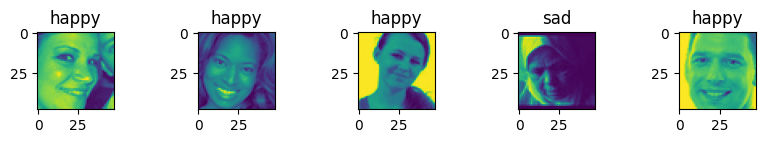

val set


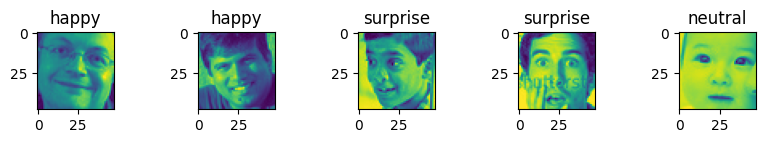

test set


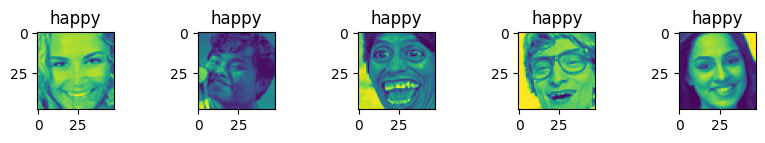

In [98]:
# Write a function to visualize images from a given data loader 
# Note: Use titles to denote class label in words.
def visualize_dataloader(dataloader, class_names):

    # Create a figure with subplots to display images
    fig, axes = plt.subplots(1, 5, figsize=(10,1))
    # figsize=(10,1) to space out images

    # Get a batch of images and labels from the data loader
    images, labels = next(iter(dataloader))

    # Loop through the first 5 images in the batch
    for i in range(5):
        image = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Un-normalize the image
        label = labels[i]  # Get the label for the image

        # Display the image in the subplot
        axes[i].imshow(image)
        axes[i].set_title(class_names[label])

    # Show the plot with the images and labels
    plt.show()
    
# visualize images from the trainloader
print('train set')
visualize_dataloader(trainloader, class_names)

# visualize images from the valloader
print('val set')
visualize_dataloader(valloader, class_names)

# visualize images from the valloader
print('test set')
visualize_dataloader(testloader, class_names)

<div class="alert alert-block alert-info">

### Design your own CNN

Here are some guidelines in the CNN you can construct (you may stray away from this if you find other architectures are better):
- 4 convolutional layers
- Some (or all) of the convolutional layers can have pooling layers (this reduces size of feature maps well!)
- Test several activation functions (ReLU, sigmoid, tanh etc.) 
- Test different optimizers (SGD usually uses lr=0.1, ADAM usually uses lr=0.001, these are only guidelines and you can tweak the learning rates based on the datasets)

In [99]:
class MyCNN(pl.LightningModule):
    
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.activation = nn.LeakyReLU()

        self.learning_rate = 0.1
        self.loss_fn = nn.CrossEntropyLoss()

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)


    def forward(self, x):
        
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))
        x = self.pool(self.activation(self.bn5(self.conv5(x))))

        x = torch.flatten(x, 1)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        
        return x


    def training_step(self, batch, batch_idx):
        # Define logic for training step
        
        x,y = batch
        logits = self(x)
        pred = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.train_accuracy.update(pred, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        
        return loss

    def validation_step(self, batch, batch_idx):
        # Define logic for validation step
        x, y = batch
        # pass through the network
        logits = self(x)
        # Get the loss
        pred = logits.argmax(1)
        loss = self.loss_fn(logits,y)
        self.val_accuracy.update(pred, y)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        # Define logic for test step
        x, y = batch
        # pass through the network
        logits = self(x)
        pred = logits.argmax(1)
        # Get the loss
        loss = self.loss_fn(logits,y)
        self.test_accuracy.update(pred, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return logits
        
    def predict_step(self, batch, batch_idx):
        # Define logic for inference/prediction step
        x,y = batch
        logits = self(x)
        pred = logits.argmax(dim=1)

        return (pred, y, x)

    def configure_optimizers(self):
        # Configure optimizers and schedulers
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

### Initialize the CNN

In [100]:
task3_model = MyCNN(num_classes=num_classes) # intialize CNN

# print summary of the model to double check
summary(task3_model, (1, 48,48)) # delete .to('cuda') if not using cpu

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
         LeakyReLU-3           [-1, 32, 48, 48]               0
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
       BatchNorm2d-6           [-1, 64, 24, 24]             128
         LeakyReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
      BatchNorm2d-10          [-1, 128, 12, 12]             256
        LeakyReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 256, 6, 6]         295,168
      BatchNorm2d-14            [-1, 25

### Define progress bar and checkpoint callback functions 

In [101]:
# Define checkpoint callback function to save the model at the best epoch
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    save_top_k=1,        # save the best model based on validation accuracy
    mode="max",
    every_n_epochs=1
)

### Train the CNN

In [102]:
task3_trainer = pl.Trainer(
    accelerator="auto",
    devices = 1 if not torch.cuda.is_available() else torch.cuda.device_count(),  
    max_epochs=20,
    callbacks=[checkpoint_callback],
    logger=CSVLogger(save_dir="./logs/task_2"),
) # Call pl.Trainer and put in the relevant arguments

#task3_trainer.fit(task3_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Test the CNN

For a propoer trained network, you may achieve an accuracy for at least 65%

In [103]:
task3_trainer.test(task3_model) 

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3488692343235016
        test_loss           1.3784013986587524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3784013986587524, 'test_acc': 0.3488692343235016}]

### Read logs

In [104]:
metrics_task_3 =  pd.read_csv("logs/task_2/lightning_logs/version_1/metrics.csv")
metrics_task_3.set_index("epoch", inplace=True)
metrics_task_3 = metrics_task_3.groupby(level=0).sum().drop("step", axis=1) 
checkpoint_task3 = torch.load('logs/task_2/lightning_logs/version_1/checkpoints/epoch=18-step=2109.ckpt')
state_dict_task3 = checkpoint_task3['state_dict']
task3_model.load_state_dict(state_dict_task3)

C:\Users\cgreg\AppData\Local\Temp\ipykernel_11424\1610293992.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_task3 = torch.load('logs/task_2/lightning_logs/ve

<All keys matched successfully>

### Plot train and validation losses against epoch

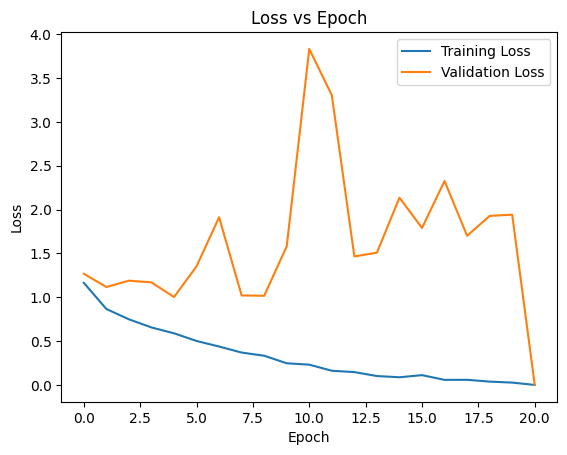

In [105]:
# Create a figure with all the appropriate labels/titles etc.

plt.plot(metrics_task_3.index, metrics_task_3["train_loss"], label="Training Loss")
plt.plot(metrics_task_3.index, metrics_task_3["val_loss"], label="Validation Loss")

# Set plot title and labels
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


### Plot train and validation accuracies against epoch

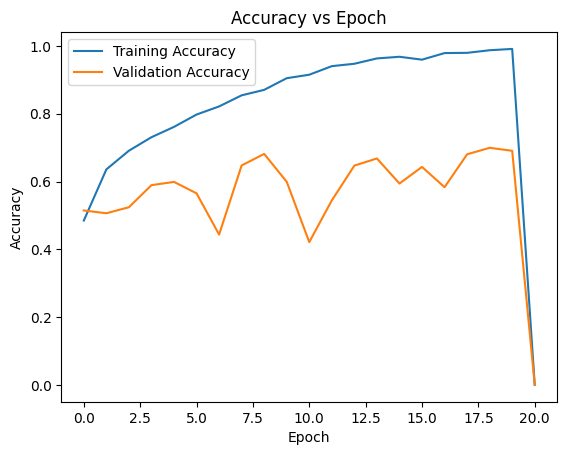

In [106]:

plt.plot(metrics_task_3.index, metrics_task_3["train_acc"], label="Training Accuracy")
plt.plot(metrics_task_3.index, metrics_task_3["val_acc"], label="Validation Accuracy")

# Set plot title and labels
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


### Get predictions for the test set for later use 

In [107]:
## These are the predictions for the test set. You will use this for the tasks below during the analysis process.

predictions = task3_trainer.predict(task3_model, testloader) # do not do anything to the variable 'predictions' you will reuse it

test_outputs = torch.concat([prediction[0] for prediction in predictions], dim=0)
test_labels = torch.concat([prediction[1] for prediction in predictions], dim=0)
test_inputs = torch.concat([prediction[2] for prediction in predictions], dim=0)
task3_model.eval()

# Assuming `test_inputs` is your data and `model` is your trained model
with torch.no_grad():  # Disable gradient computation for faster inference
    logits = task3_model(test_inputs)
test_probs = torch.softmax(logits, dim=1)
test_preds = torch.argmax(test_probs, dim=1)

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Confusion Matrix

Ensure you use **proportion** instead of absolute value. Create the confusion matrix for the four classes.

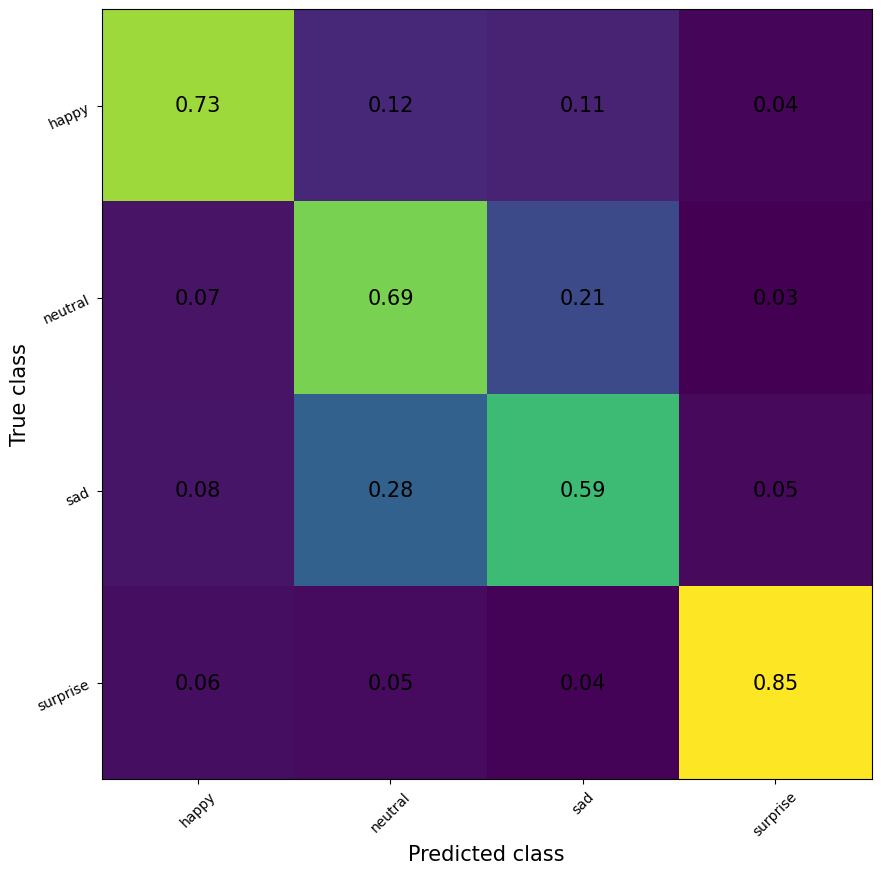

In [108]:
# Plot the confusion matrix
# You can create a ConfusionMatrix instance for multiclass classification with 'num_classes' from the lightning library
cm = torchmetrics.ConfusionMatrix('multiclass',num_classes=num_classes,normalize='true')
cm.update(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(12, 10))

cm_plot = cm.plot(ax=ax, labels=class_names)

### Top Misclassified

You will only plot the top misclassified classes here. Please plot 5 images of each class (so 20 images in total). This will be similar to the basics notebook.

Class 0: Misclassified for happy


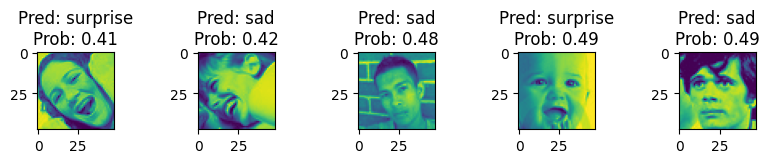

Class 1: Misclassified for neutral


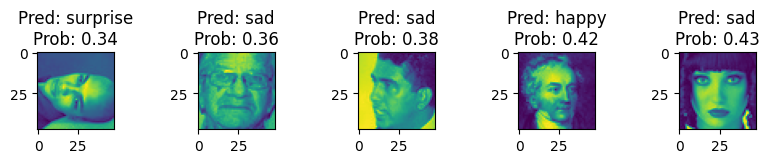

Class 2: Misclassified for sad


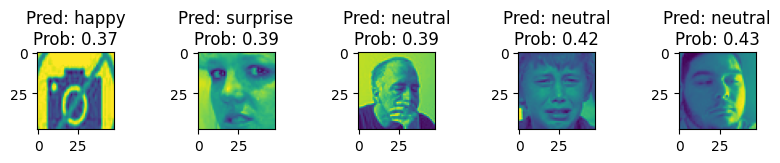

Class 3: Misclassified for surprise


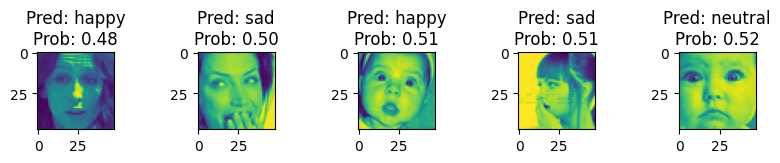

In [109]:
wrong_predictions = test_preds != test_labels

for c in range(num_classes):
    # Indices for class
    class_indices = (test_labels == c).nonzero(as_tuple=True)[0]
    print(f"Class {c}: Misclassified for {class_names[c]}")

    fig, axes = plt.subplots(1, 5, figsize=(10, 1))  # Subplots to visualize 5 images
    class_wrong_indices = class_indices[wrong_predictions[class_indices]]

    class_predicted_labels = test_preds[class_wrong_indices]

    class_probs = test_probs[class_wrong_indices, class_predicted_labels]
    low_k_values, low_k_indices = torch.topk(class_probs, k=5, largest=False)
    top_5_misclassified_indices = class_wrong_indices[low_k_indices]

    # Loop through the first 5 examples of this class
    for i, idx in enumerate(top_5_misclassified_indices):
        image = test_inputs[idx].permute(1, 2, 0) * 0.5 + 0.5  # Un-normalize image (assuming normalization was applied)
        
        # Fetch the predicted label and the corresponding probability
        # Probability of the top predicted class
        top_class_prob = low_k_values[i].item()
        predicted_label = test_preds[idx].item()
        # Display the image in the subplot
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {class_names[predicted_label]}\nProb: {top_class_prob:.2f}")

    # Show the plot with the images and predicted labels
    plt.show()

### Saliency Map

Plot a saliency map corresponding to a happy face that was classified correctly

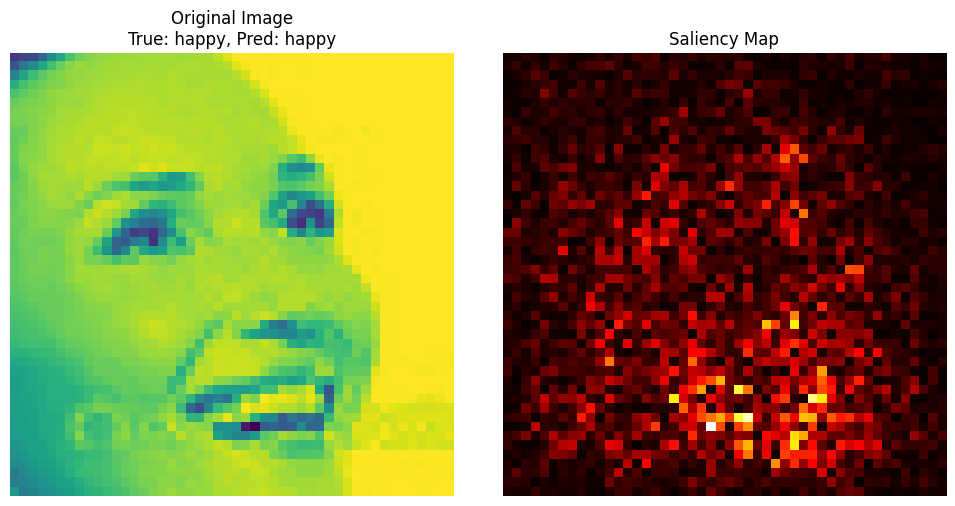

In [110]:
# Find indices of correctly classified test samples
correct_preds = (test_preds == test_labels) & (test_labels == class_names.index('happy'))

# Select a random index from the correctly classified samples
correct_indices = torch.where(correct_preds)[0]
random_index = random.choice(correct_indices.tolist())

# Retrieve the input image, true label, model output, predicted label for the selected index
selected_image = test_inputs[random_index]
true_label = test_labels[random_index].item()
predicted_label = test_preds[random_index].item()

# Add a batch dimension to the input image and set requires_grad to True for saliency analysis
image = selected_image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
task3_model.eval()  # Set the model to evaluation mode
scores = task3_model(image)
score_max = scores[0, predicted_label]
task3_model.zero_grad()
score_max.backward()

# Calculate the saliency map
saliency, _ = torch.max(image.grad.data.abs(), dim=1)

# Create a subplot to display the original image and saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
unnormalized_image = selected_image.detach().cpu() * 0.5 + 0.5
unnormalized_image = unnormalized_image.permute(1, 2, 0)
axes[0].imshow(unnormalized_image)
axes[0].axis('off')
axes[0].set_title(f'Original Image\nTrue: {class_names[true_label]}, Pred: {class_names[predicted_label]}')

# Display the saliency map
axes[1].imshow(saliency[0].cpu(), cmap='hot')
axes[1].axis('off')
axes[1].set_title('Saliency Map')

plt.tight_layout()
plt.show()

### My own image

Use an image of yourself being happy - hopefully you are proud of your results! Make sure you output the predicted result

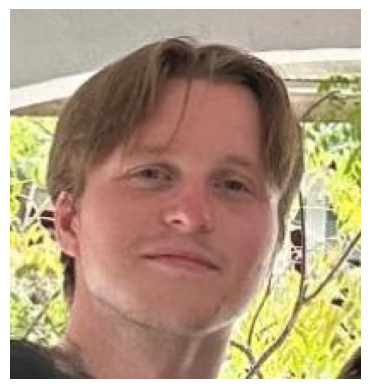

In [111]:
# Read in your image here (we used mpimg.imread and you just need to pass in the path to your image)
# Feel free to use any other image reading functions instead
img = mpimg.imread("meImage.jpg")[:,:,0:3]  # get rid of the 4th axis if exists
plt.imshow(img)
plt.axis('off')
plt.show()

In [112]:
# Pass your image through the network
# Remember to apply the val_test_transforms for your image before doing a forward pass of your model

img_tensor = val_test_transforms(img).unsqueeze(0)  # Add batch dimension

# Pass the image through the network
with torch.no_grad():
    output = task3_model(img_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f"Predicted class: {predicted_class.item()}")

# If you have class labels, you can map the predicted class to its label
predicted_label = class_names[predicted_class.item()]
print(f"Predicted emotion: {predicted_label}")
# I woudl say this is neurtal or happy depending on the interpretation

Predicted class: 2
Predicted emotion: sad


<div class="alert alert-block alert-success">

## Discussion Questions <a class="anchor" id="t3_1"></a>
    
#### Comment on the resulting confusion matrix.
    
Answer: The model is best at classifying suprprise then happiness. Sadness and nurtral is where the model missclassifies the most.

#### What was the strange thing that you observed in the actual labels when visualizing the misclassified images?
    
Answer: The miosclassified images included a lot of babies as well as ambigous emotions on their faces. This could indicate that the model struggles with ege cases such as these.
    
#### Comment on the saliency map of the 'happy' image.
    
Answer: It is mostly highlighted around the mouth and eyes. That makes sense since those are the most clear indicators of happiness. 
    
#### Comment on the prediction results of your own data.
    
Answer: The image I uploaded I would consider either neutral or happy. It was classified as sad. This could probably be due to that fact that sometimes I have a smile that is inverted. I suspect the model saw a slightly downtruned mouth and classified it as sad. This could be another edge case that the model cannot correctly handle.

<div class="alert alert-block alert-danger">

#### This is the end of Notebook II. Hurrah! You have now completed all the Labs for this unit! It's time to reward yourself with an assignment!!!